### Importing the relevant packages
If the environment is correctly setup you should be able to sucessfully import the following packages.

In [2]:
import matplotlib.pyplot as plt
from gym import spaces
from tqdm import tqdm

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent, RussoAgent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn

%matplotlib inline

### Loading the environment object and running it
In the following cell we instanciate a dynamical model (of the `ModelDynamics` class) that implements the epidemic simulation. The simulation parameters are set by the config file that we load (here `switzerland.yaml`). We then demonstrate how one can query the list of cities from the dynamical model and how one can plot the map on which the simulation will happen. 

In [3]:
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map

The size of the dots represents the population in each city, the width of the connecting edges represents how fast contamination can propagate to one city to the next. 

### Instanciating the environment object
The environment provides a wrapper for an agent to interact with. It implements a step method that allows an agent to make observations and pick actions that will impact the environment. We show how to reset the environment (which is also the procedure used for initialization and for *seeding* the random number generators).

In [4]:
"""Loading the environment"""
env = Env(  dyn, # We pass the dynamical model to the environment 
            action_space=None, # Here one could pass an openai gym action space that can then be sampled
            observation_space=None, # Here one could pass an openai gym obs space that can then be sampled
            )

""" Resetting the environment """
obs, info = env.reset(seed=0) # We pass a seed to the env to ensure reproductibility 


### Stepping throught the environment
Actions are passed to the environment as a dictionary of booleans. In the following cell we create an example `null` action.

In [6]:
action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }

Now that we have an action dictionary, we can pass it to the environment and perform an environment *step*.

In [7]:
"""One step amounts to one week in the simulation environment"""
obs, reward, done, info = env.step(action)

At each step the environment returns four variables :
1. An observation `obs` (to be used by the agent for decision making)
2. A reward `rew` (to be used for training)
3. A boolean variable `done` (indicates when an episode is finished)
4. An information object `info` (to be used for policy interpretation and debugging)

we will now show in details what each of those variables contain.

# Question 1

In [8]:
action_space        =   spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)


In [9]:
SCALE = 100
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4


def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True
        
    return action
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    infected = infected**(1/4)
    dead = dead**(1/4)
    confined = confined**(1/4)
    return torch.Tensor(np.stack((infected, dead, confined))).unsqueeze(0)

In the following cell we **instanciate an environment with set action and observation spaces attributes**. This will allow for sampling the env for example actions and observations, which we use for random actions in the example dummy agent. The action preprocessor and the observation preprocessor that we defined below are also passed to the environment.

In [10]:
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

In the following cell we show how to subclass the agent class. (Here to create a fully random dummy agent with 5 actions).

In [11]:
class ExampleAgent(Agent):
    def __init__(self,  env:Env,
                # Additionnal parameters to be added here
                ):
        """
        Example agent implementation. Just picks a random action at each time step.
        """
        self.env = env
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    def act(self, obs):
        # this takes an observation and returns an action
        # the action space can be directly sampled from the env
        return self.env.action_space.sample() 

#### Running through an episode with the dummy agent
The following cell provides an example of going through an entire episode while logging the information dictionary as it is produced.

In [12]:
agent = ExampleAgent(env)

""" Run the simulation """
log = []
finished = False
obs, info = env.reset(2)
agent.reset()
agent.epsilon = 0
while not finished:
    obs, R, finished, info = env.step(0)
    log.append(info) # save the information dict for logging
    if finished:
        break
    

""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}


In the following cell we provide an example of plotting an episode, from the log dictionnaries defined above.

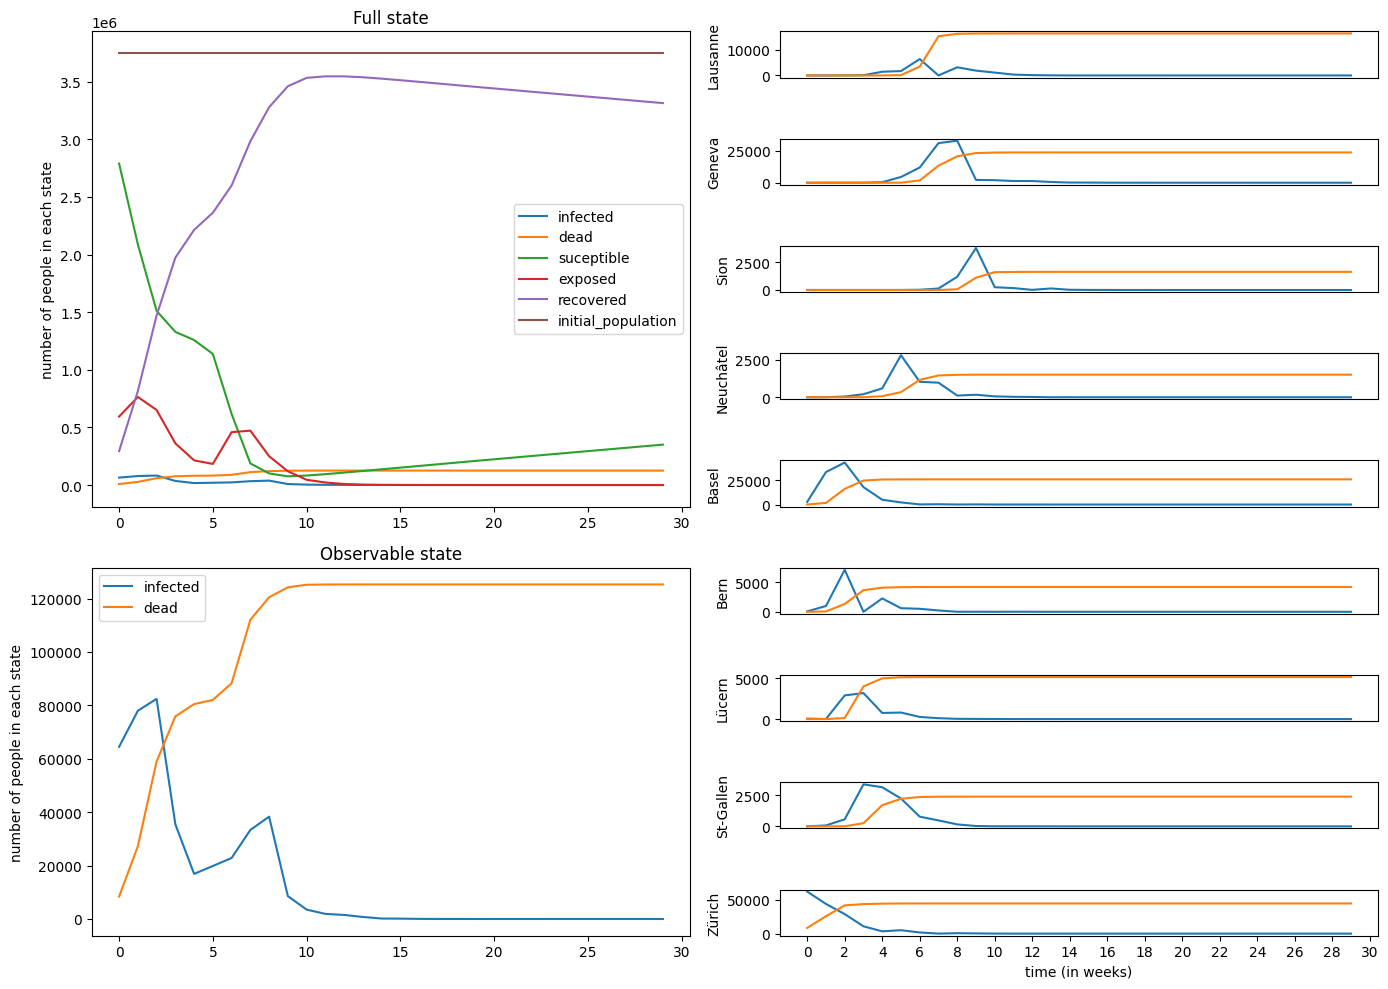

In [13]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=5)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(5, 0), rowspan=4)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax_leftstate.plot(y) for y in total.values()]
ax_leftstate.legend(total.keys())
ax_leftstate.set_title('Full state')
ax_leftstate.set_ylabel('number of people in each state')

[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state')
ax_leftobs.set_ylabel('number of people in each state')


[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Zürich'].set_xlabel('time (in weeks)')
ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

fig.tight_layout()
plt.show()

> **1.a)** When epidemics are unmitigated, the model produces an expected behavior. In the first few weeks, many people is infected, some of whom will die, while the majority will recover. The epidemic will naturally slow down as most of the population is no longer likely to catch the virus again (*left side of the above Figure*). \
The spatial spread of the epidemic is also realistic, as it starts in certain Swiss towns (depending on initialization) and then spread from one town to the next with a lag time (*right side of the above Figure*).

# Question 2
## A)

In [14]:
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            # Don't put observation preprocessor for this case because RussoAgent needs to know the population of each cities
            )

In [15]:
agent = RussoAgent(env)

""" Run the simulation """
log = []
finished = False
obs, info = env.reset(2)
agent.reset()
agent.epsilon = 0
while not finished:
    action = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break
    

""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

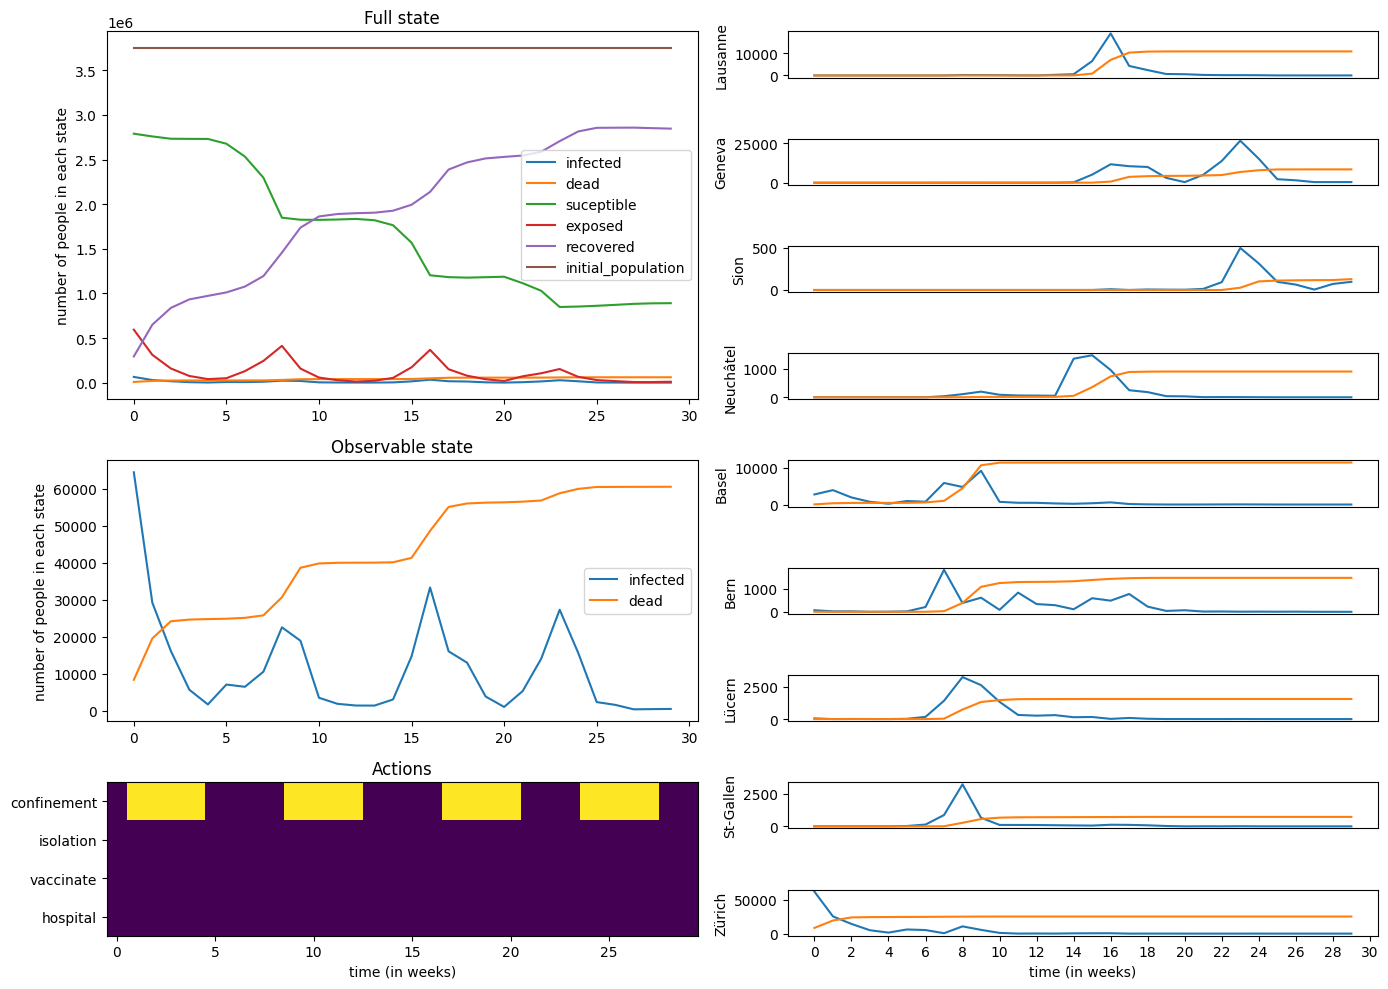

In [16]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax_leftstate.plot(y) for y in total.values()]
ax_leftstate.legend(total.keys())
ax_leftstate.set_title('Full state')
ax_leftstate.set_ylabel('number of people in each state')

[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state')
ax_leftobs.set_ylabel('number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('time (in weeks)')

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Zürich'].set_xlabel('time (in weeks)')
ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

fig.tight_layout()
plt.show()

> **2.a)** With Russo policy, the agent chooses periodically (about every 8 weeks) to confine the entire population for 4 weeks. It performs better than the unmitigated model, dividing the number of deaths by 2 after 30 weeks. However, such measures are impossible to implement in reality, due to their impact on population morale and the fact that they don't seem to contain the epidemic in the long term.

## B)

In [21]:
N_EPISODES = 50
agent = RussoAgent(env)

log = {'Episode':[i+1 for i in range(N_EPISODES)],'conf_days':[], 'R_cumul':[], 'N_deaths':[]}

""" Run several simulations """
for i in tqdm(range(N_EPISODES)):
    finished = False
    obs, info = env.reset(i)
    agent.reset()
    agent.epsilon = 0
    N_confin = 0
    R_cumul = 0

    while not finished:
        action = agent.act(obs)
        obs, R, finished, info = env.step(action)
        
        R_cumul += R
        N_confin += info.action['confinement']*7

        if finished:
            break
    
    log['conf_days'].append(N_confin)
    log['R_cumul'].append(R_cumul.numpy()[0])
    log['N_deaths'].append(info.total.dead)


100%|██████████| 50/50 [00:14<00:00,  3.52it/s]


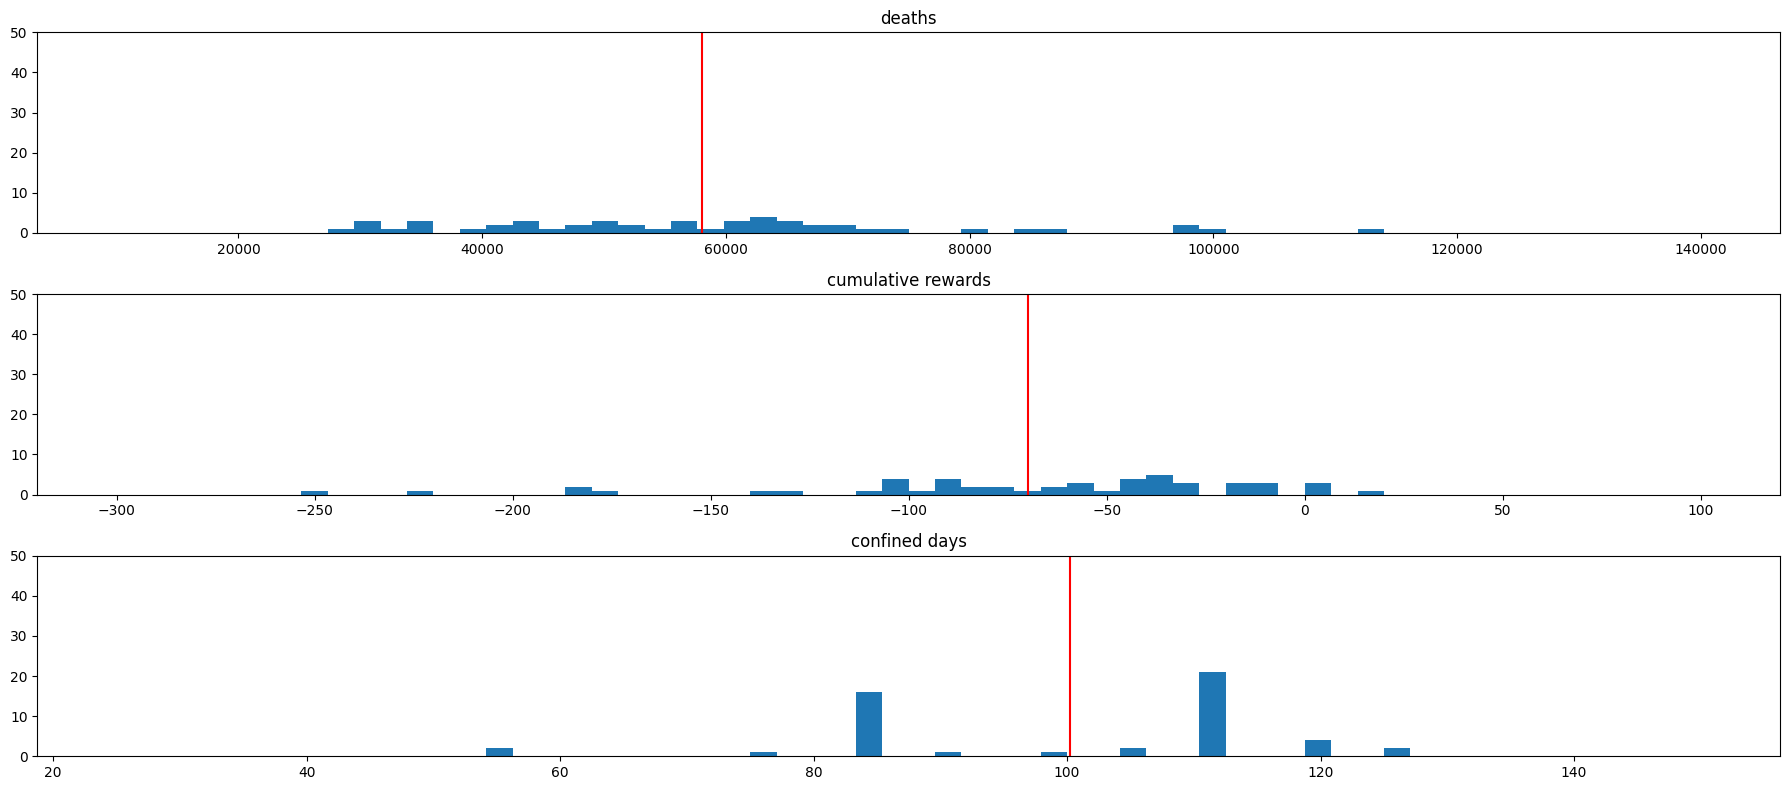

Average death number: 58071.94
Average cumulative reward: -69.96265411376953
Average number of confined days: 100.24


In [23]:
deaths = np.array(log['N_deaths'])
rewards = np.array(log['R_cumul'])
conf_days = np.array(log['conf_days'])


""" Plot example """
fig, ax = plt.subplots(3,1,figsize=(18,8))
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (10000,140000)
    elif title == 'cumulative rewards': 
        x_range = (-300,100)
    elif 'days' in title:
        x_range = (25,150)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
hist_avg(ax[0], deaths,'deaths')
hist_avg(ax[1], rewards,'cumulative rewards')
hist_avg(ax[2], conf_days,'confined days')
fig.tight_layout()
plt.show()

""" Print example """
print(f'Average death number: {np.mean(deaths)}')
print(f'Average cumulative reward: {np.mean(rewards)}')
print(f'Average number of confined days: {np.mean(conf_days)}')
#print(f'Average number of isolation days: {np.mean(conf_days)}')


# Question 3
## A)

In [17]:
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4


def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True
        
    return action
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    infected = infected**(1/4)
    dead = dead**(1/4)
    confined = confined
    return torch.Tensor(np.stack((infected, dead, confined))).unsqueeze(0)

In [18]:
action_space        =   spaces.Discrete(2)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

In [19]:
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random

class DQNAgent:
    def __init__(self, state_dim, action_dim, memory_size=20000, seed = 0):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.memory = deque(maxlen=memory_size)
        self.model = self.create_model()
        self.target_model = self.create_model()
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr = 0.005)
        self.loss_fn = nn.HuberLoss()

    def create_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, self.action_dim)
        )
        return model

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())
        
    def observation_to_state_OG(self, observation):
        state = []
        for city, observables in observation.city.items():
            state.extend(observables.infected)
            state.extend(observables.dead)
        state.extend(observation.total.infected)
        state.extend(observation.total.dead)
        return state
    
    def observation_to_state2(self, observation):
        # Initialize an empty tensor of shape (2, 9, 7)
        state = np.zeros((2, len(observation.city), 7))

        # Iterate over each city and add the 'infected' and 'dead' data to the tensor
        for i, (city, observables) in enumerate(observation.city.items()):
            #print('ICI :', observables)
            state[0, i, :] = observables.infected
            state[1, i, :] = observables.dead
        
        #print("State before FLATTEN", state.shape)
        # Flatten the tensor into a 1D array
        #print('State shape 1: ', state.shape)
        state = state.flatten()
        #print('State shape 2: ', state.shape)

        return state
    
    def observation_to_state(self, observation):
        # Initialize an empty tensor of shape (2, 9, 7)
        state = observation[0,:2]
        state = np.array(state.flatten())
        #print('State shape 2: ', state.shape)

        return state


    def act_OG(self, state, epsilon):
        if random.random() < epsilon: # Exploration
            return random.choice(range(self.action_dim))
        else: # Exploitation
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action_values = self.model(state)
            return torch.argmax(action_values).item()
        
    def act(self, state, epsilon):
        #print('state init', state)
        state = self.observation_to_state(state)
        #print('stat post', state.shape, state)
        if random.random() < epsilon: # Exploration
            return random.choice(range(self.action_dim))
        else: # Exploitation
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action_values = self.model(state)
            #print("action_values", action_values.shape, action_values, torch.argmax(action_values).item())
            return torch.argmax(action_values).item()



    def remember(self, state, action, reward, next_state, done):
        #print('Remember :', (state, action, reward, next_state, done))
        #print('State :', state)
        #print('Action :', action)
        #print('Reward :', reward)
        #print('Next state :', next_state)
        #print('Done :', done)
        state = self.observation_to_state(state)
        next_state = self.observation_to_state(next_state)
        self.memory.append((state, action, reward, next_state, done))
        #print("memory post remember :", self.memory)

    def train(self, batch_size):
        #print('ICI', len(self.memory))
        if len(self.memory) < batch_size:
            return
        #print("batch_size", batch_size)
        batch = random.sample(self.memory, batch_size)
        #print("Batch :", batch.shape)
        states, actions, rewards, next_states, dones = zip(*batch)
        print(states)
        states = np.array(states)
        print("States :", states.shape)
        next_states = np.array(next_states)
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)
        
        curr_Q = self.model(states)#.gather(1, actions.unsqueeze(1)).squeeze(1)
        print("Curr_Q :", curr_Q.shape)
        curr_Q = curr_Q.gather(1, actions.unsqueeze(1)).squeeze(1)
        print("Actions :", actions[:4])
        print("Curr_Q' :", curr_Q[:4])
        next_Q = self.target_model(next_states).max(1)[0]
        #print("Next_Q :", next_Q.shape)
        #print("Dones :", dones)
        #print('Rewards :', rewards.shape)
        target_Q = rewards + (1 - dones) * 0.9 * next_Q # 0.9 is the discount factor
        loss = self.loss_fn(curr_Q, target_Q.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# You need to adjust the state_dim and action_dim according to your environment
#state_dim = 2*9*7 # Adjust this
#action_dim = 2 # Binary action space
#agent = DQNAgent(state_dim, action_dim)


In [21]:
from tqdm import tqdm
import numpy as np
import torch

N_EPISODES = 500
EVAL_INTERVAL = 50
NUM_EVAL_EPISODES = 20
TARGET_UPDATE_INTERVAL = 5  # Update target network every 5 episodes

BATCH_SIZE = 2048
BUFFER_SIZE = 20000

epsilon_start = 0.7
epsilon_end = 0.2
epsilon_decay = 995.  # 0.995
epsilon = epsilon_start

input_shape = 126  # 2*9*7
action_size = 2  # binary action space
seed = 0  # or any other seed you want to use for reproducibility

agent = DQNAgent(input_shape, action_size, memory_size=BUFFER_SIZE, seed=seed)  # Assume you've defined input_shape, action_size, seed

log = {
    'Episode': [i + 1 for i in range(N_EPISODES)],
    'conf_days': [],
    'R_cumul': [],
    'N_deaths': [],
    'eval_trace': []
}

best_eval_reward = -np.inf

""" Run several simulations """
for i in tqdm(range(N_EPISODES)):
    finished = False
    obs, info = env.reset()
    N_confin = 0
    R_cumul = 0
    
    if i % TARGET_UPDATE_INTERVAL == 0:
        agent.update_target_model()

    while not finished:
        action = agent.act(obs, epsilon)
        next_obs, R, finished, info = env.step(action)

        R_cumul += R
        N_confin += info.action['confinement'] * 7

        # Store the transition in memory
        agent.remember(obs, action, R, next_obs, finished)

        # Train the model
        agent.train(BATCH_SIZE)  # 32 is the batch size

        obs = next_obs

        if finished:
            break
            
    # Decay epsilon
    epsilon = max(epsilon_end, epsilon * (N_EPISODES-i)/N_EPISODES)

    log['conf_days'].append(N_confin)
    log['R_cumul'].append(R_cumul.numpy()[0])
    log['N_deaths'].append(info.total.dead)

    # Evaluation and logging
    if i % EVAL_INTERVAL == 0 or (i == N_EPISODES - 1 and N_EPISODES % EVAL_INTERVAL != 0):
        eval_rewards = []
        for idx in range(NUM_EVAL_EPISODES):
            obs, _ = env.reset()
            episode_reward = 0
            done = False
            while not done:
                action = agent.act(obs, 0)  # No exploration
                obs, reward, done, _ = env.step(action)
                #print('Reward :', idx ,reward)
                episode_reward += reward
            eval_rewards.append(episode_reward)

        eval_rewards = [reward.item() for reward in eval_rewards]
        avg_eval_reward = np.mean(eval_rewards)
        log['eval_trace'].append(avg_eval_reward)
        print(f"Episode {i + 1}, Avg Eval Reward: {avg_eval_reward}")

        # Save the best model
        if avg_eval_reward > best_eval_reward:
            best_eval_reward = avg_eval_reward
            torch.save(agent.model.state_dict(), 'best_model.pt')  # Save the best model


  0%|          | 1/500 [00:05<47:20,  5.69s/it]

Episode 1, Avg Eval Reward: -152.8676025390625


 10%|█         | 51/500 [00:23<13:28,  1.80s/it]

Episode 51, Avg Eval Reward: -145.56268310546875


 14%|█▎        | 68/500 [00:28<01:57,  3.68it/s]

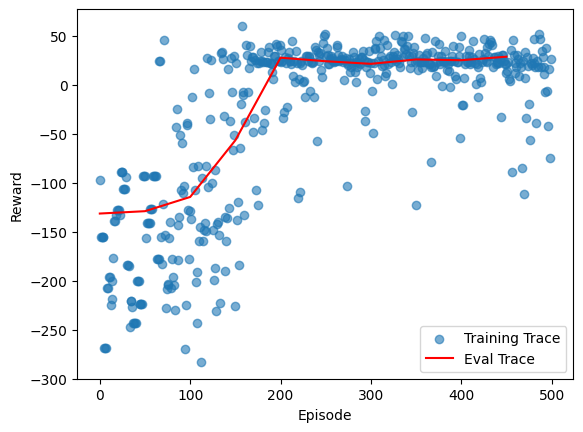

In [ ]:
import matplotlib.pyplot as plt

# Extract rewards from log
training_rewards = log['R_cumul']
eval_rewards = log['eval_trace']

# Generate x values
x_train = range(len(training_rewards))
x_eval = range(0, len(training_rewards), EVAL_INTERVAL)

# Create new figure
plt.figure()

# Plot training trace
plt.scatter(x_train, training_rewards, label='Training Trace', alpha=0.6)

# Plot evaluation trace
plt.plot(x_eval, eval_rewards, label='Eval Trace', color='red')

# Add labels and legend
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()

# Show the plot
plt.show()
